In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('training_walks.csv')
df.head()

,Unnamed: 0,transmitter,walk,i,j,rssi,tx_location_i,tx_location_j
0,0,tx0,0,2214,1812,-1000.0,1716,1337
1,1,tx0,0,2209,1812,-1000.0,1716,1337
2,2,tx0,0,2209,1817,-1000.0,1716,1337
3,3,tx0,0,2209,1822,-1000.0,1716,1337
4,4,tx0,0,2204,1822,-1000.0,1716,1337


# API Integration

In [1]:
# given API wrapper
from typing import Dict, Optional, Tuple
import requests
from requests.adapters import HTTPAdapter
import numpy as np

class RemoteEvaluationEnv:
    """Wraps the hackathon API so participants can code against identical API.
    Each reset() generates a new walk_id, and step() automatically uses the current walk."""
    def __init__(
        self,
        team_id: str,
        transmitter_id: str,
        base_url: str = "https://tx-hunt.distspec.com",
    ):
        self.base = base_url.rstrip("/")
        self.team = team_id
        self.tx = transmitter_id
        self._walk_counter: int = np.random.randint(100000)
        self.current_walk_id: Optional[int] = None

        # --- NEW: one Session for all HTTP calls ---
        self.session = requests.Session()
        # tune your pool sizes if you need higher concurrency
        adapter = HTTPAdapter(pool_connections=10, pool_maxsize=50)
        self.session.mount("http://", adapter)
        self.session.mount("https://", adapter)
        # ensure keep-alive (requests does this by default, but explicit is OK)
        self.session.headers.update({"Connection": "keep-alive"})

    def reset(self) -> Dict:
        """
        Starts a fresh walk: increments walk_id, calls /start, and returns:
        {"walk_id": int, "ij":(i,j), "xy":(x,y), "rssi": rssi}
        """
        self._walk_counter += 1
        self.current_walk_id = self._walk_counter
        payload = {
            "team_id": self.team,
            "walk_id": self.current_walk_id,
            "transmitter_id": self.tx,
        }

        resp = self.session.post(f"{self.base}/start", json=payload, timeout=5)
        resp.raise_for_status()
        data = resp.json()
        data["walk_id"] = self.current_walk_id
        return data

    def step(self, action: int, circle: Optional[Tuple[int, int, float]] = None) -> Dict:
        """
        Sends one move in the current walk_id.
        Actions are: 0=N, 1=S, 2=E, 3=W.
        Optionally includes a localization guess: (i, j, r) as a circle.
        Returns: {"walk_id": int, "ij":(i,j), "xy":(x,y), "rssi": rssi}
        """
        if self.current_walk_id is None:
            raise RuntimeError("Call reset() before step()")

        payload = {
            "team_id": self.team,
            "walk_id": self.current_walk_id,
            "transmitter_id": self.tx,
            "action": action,
        }
        if circle:
            payload["locale"] = {"i": circle[0], "j": circle[1], "r": circle[2]}

        resp = self.session.post(f"{self.base}/step", json=payload, timeout=5)
        if resp.status_code == 403:
            raise ValueError(f"Illegal move in walk {self.current_walk_id}")
        resp.raise_for_status()

        data = resp.json()
        data["walk_id"] = self.current_walk_id
        return data

In [14]:
testCall = RemoteEvaluationEnv('saucetin_reaves', 'tx9')
testCall.reset()


{'ij': [2219, 1812], 'rssi': -3.4028234663852886e+38, 'walk_id': 86057}

In [15]:
# 1 step smallest radius
import sys
testCall.step(1, (1716, 1337, sys.float_info.min))

{'ij': [2219, 1811],
 'rssi': -3.4028234663852886e+38,
 'locale': {'i': 1716, 'j': 1337, 'r': 2.2250738585072014e-308},
 'walk_id': 86057}

In [8]:
testCall.step(0, (1716, 1337, 1))

HTTPError: 400 Client Error: Bad Request for url: https://tx-hunt.distspec.com/step

# Map Testing

In [ ]:
signal_received = df[df['rssi'] != -1000.0].copy()
signal_not_received = df[df['rssi'] == -1000.0].copy()

df_signal = signal_received
tx_signal = df_signal[df_signal['transmitter'] == 'tx2'].copy()
print(tx_signal['rssi'].max())
print(tx_signal['rssi'].min())

-79.638084
-230.86049


In [ ]:
# OFFICIAL SAM FUNCTIONS FROM NOTEBOOK
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

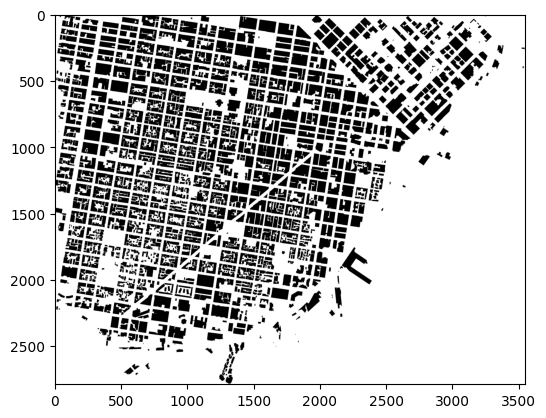

In [ ]:
test_img = cv.imread("walkable_mask.png")
test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
plt.imshow(test_img)

803


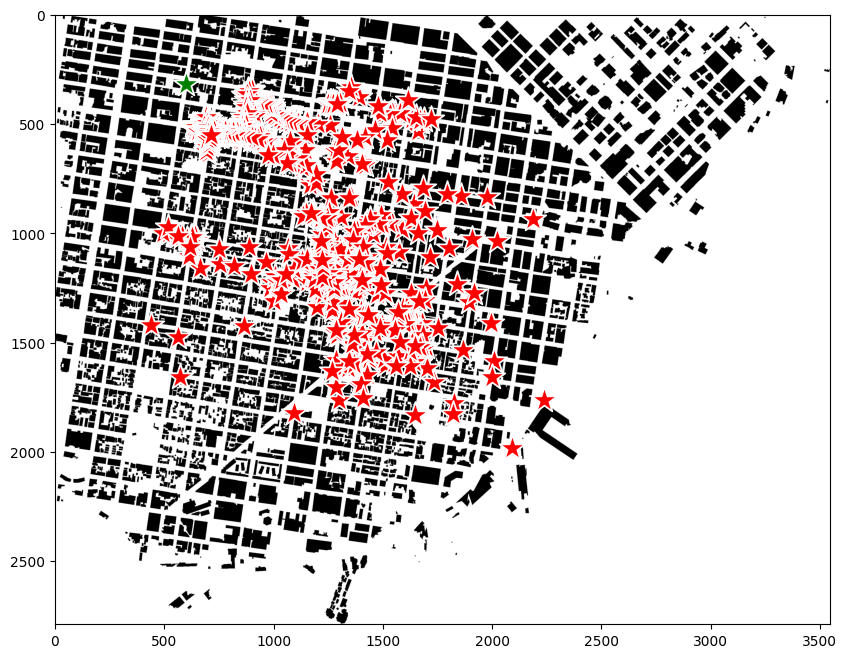

In [ ]:
df_signal = tx_signal

#present_loc, ground_truth

ground_truth = [df_signal.iloc[0]['tx_location_i'], df_signal.iloc[0]['tx_location_j']]
input_points = [ground_truth]
input_labels = [1]

ts = np.arange(0, len(df_signal), 5)
print(len(ts))
for t in ts:
    present_loc = [df_signal.iloc[t]['i'], df_signal.iloc[t]['j']]
    input_points.append(present_loc)
    input_labels.append(0)

input_points = np.array(input_points)
input_labels = np.array(input_labels)

plt.figure(figsize=(10,10))
plt.imshow(test_img)
show_points(input_points, input_labels, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
lined_img = test_img.copy()
df_signal = tx_signal

ground_truth = [df_signal.iloc[0]['tx_location_i'], df_signal.iloc[0]['tx_location_j']]
input_points = [ground_truth]
input_labels = [1]

#ts = np.arange(0, len(df_signal), 10)
ts = np.arange(0, 2000, 200)
maxMagnitude = tx_signal['rssi'].min()
print(len(ts))
for t in ts:
    present_loc = [df_signal.iloc[t]['i'], df_signal.iloc[t]['j']]

    # linearly map to color
    normalizedColor = round(255 * df_signal.iloc[t]['rssi'] / maxMagnitude)
    if normalizedColor == 255:
      lined_img = cv.line(lined_img, (ground_truth[0], ground_truth[1]), (present_loc[0], present_loc[1]), (normalizedColor, normalizedColor, normalizedColor), 5)
    else:
      lined_img = cv.line(lined_img, (ground_truth[0], ground_truth[1]), (present_loc[0], present_loc[1]), (normalizedColor, 0, normalizedColor), 10)


10


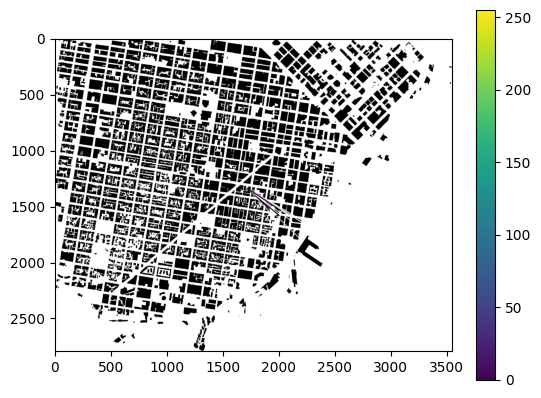

In [ ]:
img = plt.imshow(lined_img)
plt.colorbar(img)


# Test Model

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.9 MB/s eta 0:00:00


In [ ]:
import argparse
from pathlib import Path
from typing import Tuple, Dict, List
import json
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import wandb

from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATv2Conv
from torch_geometric.utils import to_undirected

In [ ]:
class RFEncoder(nn.Module):
    def __init__(self, in_dim: int = 2, hid: int = 64, heads: int = 2):
        super().__init__()
        self.conv1 = HeteroConv(
            {
                ('pixel', 'adjacent', 'pixel'):  # ← 3-tuple!
                    GATv2Conv(in_dim, hid,
                              heads=heads,
                              concat=False,
                              add_self_loops=False),
                ('pixel', 'ray', 'pixel'):       # ← 3-tuple!
                    GATv2Conv(in_dim, hid,
                              heads=heads,
                              concat=False,
                              add_self_loops=False),
            },
            aggr='mean',
        )

        self.conv2 = HeteroConv(
            {
                ('pixel', 'adjacent', 'pixel'):
                    GATv2Conv(hid, hid,
                              heads=heads,
                              concat=False,
                              add_self_loops=False),
                ('pixel', 'ray', 'pixel'):
                    GATv2Conv(hid, hid,
                              heads=heads,
                              concat=False,
                              add_self_loops=False),
            },
            aggr='mean',
        )

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict


class RFPredictor(nn.Module):
    def __init__(self, node_dim=64):
        super().__init__()
        self.enc = RFEncoder() # ! changed from out_dim=node_dim
        self.mlp = nn.Sequential(
            nn.Linear(node_dim * 2, node_dim),
            nn.ReLU(),
            nn.Linear(node_dim, 1),
        )

    def forward(self,
                data: HeteroData,
                tx_idx,
                rx_idx):
        # --- 1. get pixel embeddings ------------------------------------
        z = self.enc(data.x_dict, data.edge_index_dict)["pixel"]

        # --- 2. normalise the indices -----------------------------------
        tx_idx = torch.as_tensor(tx_idx, dtype=torch.long, device=z.device)
        rx_idx = torch.as_tensor(rx_idx, dtype=torch.long, device=z.device)

        if tx_idx.dim() == 0:
            tx_idx = tx_idx.unsqueeze(0)
            rx_idx = rx_idx.unsqueeze(0)

        # --- 3. gather & predict ----------------------------------------
        pair_emb = torch.cat([z[tx_idx], z[rx_idx]], dim=-1)
        pred = self.mlp(pair_emb).squeeze(-1)
        return pred

def load_walkable_nodes(mask_path: Path, cell_size: int) -> Tuple[np.ndarray, Dict[Tuple[int, int], int]]:
    img = Image.open(mask_path).convert("L")  # grayscale
    mask = np.array(img) > 0  # bool
    pooled = pool_mask(mask, cell_size)
    coords = np.argwhere(pooled)  # (row, col)
    id_map = {tuple(coord): idx for idx, coord in enumerate(coords)}
    return coords, id_map, pooled.shape[::-1]  # coords, map, (Wc, Hc)


# -----------------------------------------------------------
# Graph edge construction helpers
# -----------------------------------------------------------

def make_adjacent_edges(coords: np.ndarray, id_map: Dict[Tuple[int, int], int]) -> List[Tuple[int, int]]:
    dirs = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]], dtype=int)
    edges = []
    for coord in coords:
        for d in dirs:
            nb = tuple(coord + d)
            if nb in id_map:
                edges.append((id_map[tuple(coord)], id_map[nb]))
    return edges


def bresenham(p0: Tuple[int, int], p1: Tuple[int, int]) -> List[Tuple[int, int]]:
    x0, y0 = p0
    x1, y1 = p1
    dx = abs(x1 - x0)
    dy = -abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx + dy
    line = []
    while True:
        line.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 >= dy:
            err += dy
            x0 += sx
        if e2 <= dx:
            err += dx
            y0 += sy
    return line


def make_ray_edges(df: pd.DataFrame, id_map: Dict[Tuple[int, int], int], S: int) -> List[Tuple[int, int]]:
    edges = set()
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Trace rays"):
        tx = downsample_coord(int(row.tx_location_i), int(row.tx_location_j), S)
        rx = downsample_coord(int(row.i), int(row.j), S)
        if tx not in id_map or rx not in id_map:
            continue
        for p0, p1 in zip(bresenham(tx, rx)[:-1], bresenham(tx, rx)[1:]):
            if p0 in id_map and p1 in id_map:
                u, v = id_map[p0], id_map[p1]
                edges.add((u, v))
                edges.add((v, u))
    return list(edges)

def pool_mask(mask: np.ndarray, cell_size: int = 4):
    h, w = mask.shape
    h_crop = (h // cell_size) * cell_size         # largest multiple ≤ h
    w_crop = (w // cell_size) * cell_size
    mask = mask[:h_crop, :w_crop]                 # throw away the ragged fringe

    # now safe to reshape/pool
    pooled = mask.reshape(h_crop // cell_size, cell_size,
                          w_crop // cell_size, cell_size
                         ).max(axis=(1, 3))       # OR .mean(...)
    return pooled


def downsample_coord(row: int, col: int, S: int) -> Tuple[int, int]:
    """Map original‑resolution (row, col) to coarse grid indices."""
    return row // S, col // S

testing part

In [ ]:
## loading model .pt weights
device=torch.device('cuda')
state_dict = torch.load('best_model.pt',
                        map_location=torch.device("cuda"),
                        weights_only=True
                       )

hidden_dim = 64
model = RFPredictor(hidden_dim).cuda()
model = model.to(device)
model.load_state_dict(state_dict)


cell_size = 4

coords, id_map, (Wc, Hc) = load_walkable_nodes('walkable_mask.png', cell_size)
adj = make_adjacent_edges(coords, id_map)
df = pd.read_csv('training_walks.csv', delimiter=',')

CACHE = f"ray_edges_cs{cell_size}.pt"
if not os.path.exists(CACHE):
    ray = make_ray_edges(df, id_map, cell_size)
    tmp = CACHE + ".tmp"
    torch.save({"cell_size": cell_size,
                "edge_index": ray}, tmp)
    os.replace(tmp, CACHE)      # atomic move
else:
    blob = torch.load(CACHE)
    assert blob["cell_size"] == cell_size
    ray = blob["edge_index"]

data = HeteroData()
# node features: normalised coarse‑grid coords (x=j, y=i)
xy = coords[:, [1, 0]].astype(np.float32)
xy[:, 0] /= Wc; xy[:, 1] /= Hc
data["pixel"].x = torch.from_numpy(xy)
def to_idx(e):
    return to_undirected(torch.tensor(e, dtype=torch.long).t())
data["pixel", "adjacent", "pixel"].edge_index = to_idx(adj)
data["pixel", "ray", "pixel"].edge_index = to_idx(ray)

# Test Model Against Known Example

In [ ]:
df[0:40000]

,Unnamed: 0,transmitter,walk,i,j,rssi,tx_location_i,tx_location_j
0,0,tx0,0,2214,1812,-1000.000000,1716,1337
1,1,tx0,0,2209,1812,-1000.000000,1716,1337
2,2,tx0,0,2209,1817,-1000.000000,1716,1337
3,3,tx0,0,2209,1822,-1000.000000,1716,1337
4,4,tx0,0,2204,1822,-1000.000000,1716,1337
...,...,...,...,...,...,...,...,...
39995,39995,tx0,3,1849,1341,-89.785904,1716,1337
39996,39996,tx0,3,1854,1341,-84.030945,1716,1337
39997,39997,tx0,3,1854,1336,-89.072365,1716,1337
39998,39998,tx0,3,1854,1331,-92.846150,1716,1337


In [ ]:
walkable_mask[2001, 1570]

np.True_

In [ ]:
tx_signal = df[df['transmitter'] == 'tx2'].copy()
tx = (tx_signal.iloc[0]['tx_location_i'], tx_signal.iloc[0]['tx_location_j'])
print(model(data.cuda(), 998, 998))

tensor([-524.6912], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [ ]:
# find rssi value for i = 2001, j = 1570
testRSSI = tx_signal[(tx_signal['i'] == 2001) & (tx_signal['j'] == 1570)]
print(testRSSI['rssi'])

640998   -1000.0
Name: rssi, dtype: float64


In [ ]:
tx_signal = df[df['transmitter'] == 'tx2'].copy()
tx = (tx_signal.iloc[0]['tx_location_i'], tx_signal.iloc[0]['tx_location_j'])

ptLen = np.arange(0, 2000, 200)
print(len(ptLen))
RSSIvals = np.zeros(len(ptLen))
for i, val in enumerate(ptLen):
  print(i)
  # RSSIvals[i] = model(data.cuda(), i, i)
  RSSIvals[i] = model(data, val, val)#.cpu().detach().numpy()

10
0
1
2
3
4
5
6
7
8
9


In [ ]:
print(RSSIvals)
print(ground)

[-482.99450684 -532.59130859 -540.71917725 -536.41448975 -531.58428955
 -524.86920166 -541.46417236 -538.0602417  -533.2300415  -498.96679688]
[np.float64(-1000.0), np.float64(-1000.0), np.float64(-1000.0), np.float64(-1000.0), np.float64(-1000.0), np.float64(-157.34523), np.float64(-1000.0), np.float64(-142.09225), np.float64(-1000.0), np.float64(-138.13744)]


In [ ]:
iVals = []
jVals = []
ground = []
for i, val in enumerate(ptLen):
  ground.append(df.iloc[int(val)]['rssi'])
  iVals.append(df.iloc[int(val)]['i'])
  jVals.append(df.iloc[int(val)]['j'])

#jVals[0] = df.iloc[2003]['j']
print(jVals)

[np.int64(1812), np.int64(1707), np.int64(1640), np.int64(1638), np.int64(1572), np.int64(1580), np.int64(1594), np.int64(1519), np.int64(1559), np.int64(1537)]


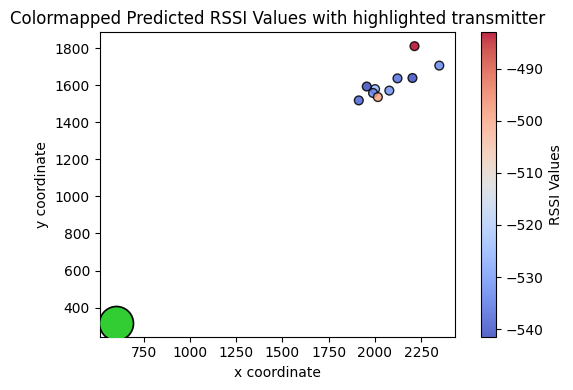

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

# 1️⃣  base scatter coloured by z_val
sc = ax.scatter(iVals, jVals,
                c=RSSIvals,
                cmap='coolwarm',
                s=40,
                edgecolor='k',
                alpha=0.85)

fig.colorbar(sc, ax=ax, label='RSSI Values')

# 2️⃣  big green circle on top
x0, y0 = 2, 3           # coordinates of the point you want to spotlight
ax.scatter(tx[0], tx[1],
           s=600,                # marker *area* (points²) – make larger if needed
           c='limegreen',        # face colour
           edgecolor='k',        # thin outline (optional)
           linewidth=1.2,
           zorder=3)             # keep it above the background points

# tidy up
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_title('Colormapped Predicted RSSI Values with highlighted transmitter')
ax.set_aspect('equal')           # optional, for round circles

plt.tight_layout()
plt.show()

In [ ]:
lined_img2 = test_img.copy()
df_signal = tx_signal

ground_truth = [df_signal.iloc[0]['tx_location_i'], df_signal.iloc[0]['tx_location_j']]
input_points = [ground_truth]
input_labels = [1]

ts = np.arange(0, len(df_signal), 10)
maxMagnitude = tx_signal['rssi'].min()

normalizedColors = np.round(np.array(255 * RSSIvals / maxMagnitude))

for i, val in enumerate(ptLen):
  present_loc = [df_signal.iloc[val]['i'], df_signal.iloc[val]['j']]
  # linearly map to color
  #RSSIvals = model(data, i, i)
  normalizedColor = int(normalizedColors[i])
  if normalizedColor == 255:
    lined_img2 = cv.line(lined_img2, (ground_truth[0], ground_truth[1]), (present_loc[0], present_loc[1]), (normalizedColor, normalizedColor, normalizedColor), 5)
  else:
    lined_img2 = cv.line(lined_img2, (ground_truth[0], ground_truth[1]), (present_loc[0], present_loc[1]), (normalizedColor, 0, normalizedColor), 10)


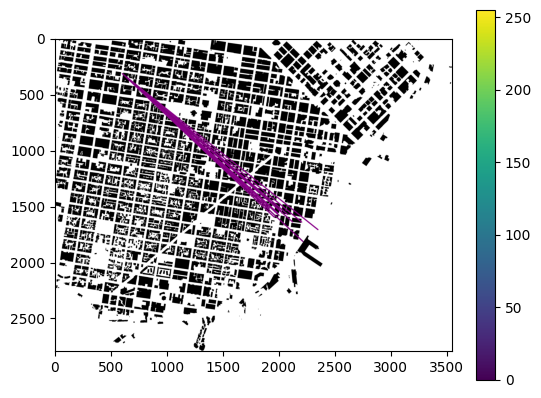

In [ ]:
img2 = plt.imshow(lined_img2)
plt.colorbar(img2)

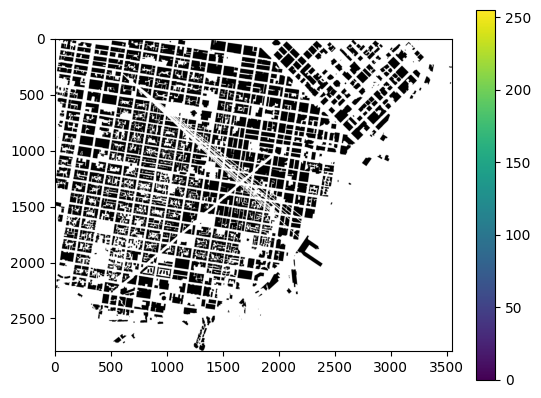

In [ ]:
img = plt.imshow(lined_img)
plt.colorbar(img)

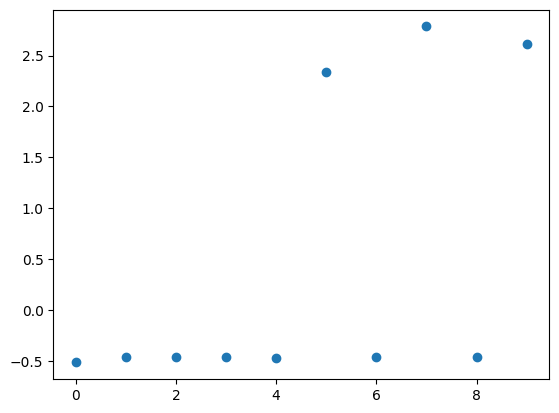

In [ ]:
plt.scatter(np.arange(0, 10), (RSSIvals - ground)/ground)

# Walkable Mask Def

In [ ]:
# bool map
import PIL.Image as Image
im = Image.open("walkable_mask.png")
walkable_mask = np.asarray(im, dtype=bool) == 0

In [ ]:
walkable_mask.shape

(2789, 3546)

In [ ]:
walkable_mask[1500, 50]

np.True_

# Pathfinding Algo

veej approach

In [ ]:
# gen
# compile all transmitter position maps
# edge connectivity values to draw ray

Cruder Approach

In [ ]:
# compile all transmitter possibilities

# while outside acceptable zone
  # measure a (pos: RSSI)
  # if that map does not contain that value (+tolerance) in the neighborhood or check (p+eps: RSSI+tol) then remove it
  # pick highest value area / min entropy manuever


# once in near, globally optimize - gaussian assumption?

In [ ]:
# compile all transmitter possibilities
# RSSI_maps = np.array([])
# tempMap = np.zeros(walkable_mask.shape)

# for i in range(walkable_mask.shape[0]):
  # for j in range(walkable_mask.shape[1]):
    # for k in range(walkable_mask.shape[0]):
      # for l in range(walkable_mask.shape[1]):
        # tempMap[k, l] = model(transmitter_pos=(i, j), receiver_pos=(k, l))
    # RSSI_maps.append(tempMap)
    # tempMap = np.zeros(walkable_mask.shape)

# these should have a 1-to-1 correspondence such that transmitter_positions[i] --> RSSI_maps[i]
# form of ordered pair points
transmitter_positions = [(1, 1), ...]
# form of array of nparray matrix of RSSI values
RSSI_maps = [map1, map2, ...]
valid_indices = [True, True, ...]

# experiment with these tolerances
tolRSSI = 10 # allowed variance in RSSI score
tolPos = 50 # allowed variance in location in plus/minus x, y
tolNear = 250 # ballpark near-field to stop and globally optimize over
avg_target_pos = 10**8

# initialize
#current_pos = val from API call

# while outside acceptable zone
while abs(avg_target_pos - current_pos) > tolNear:
  # measure a (pos: RSSI) with API call
  newRSSI = measure(current_pos)

  # if that map does not contain that value (+tolerance) in the neighborhood or check (p+eps: RSSI+tol) then remove it
  for i, map in enumerate(RSSI_maps):
    if abs(map[current_pos[0], current_pos[1]] - newRSSI) > tolRSSI:
      RSSI_maps.remove(map)
      valid_indices[i] == False

    # CHECK AROUND THE NEIGHBORHOOD FIX THIS LATER --> ALSO CHECK FOR WALKABLE LOCATIONS
    # for i in np.arrange(0, tolPos, 5):
    #   for j in [-1, 1]:
    #     if abs(map[current_pos + (j * i, 0)] - newRSSI) > tolRSSI:
    #       RSSI_maps.remove(map)
    #     if abs(map[current_pos + (0, j * i)] - newRSSI) > tolRSSI:
    #       RSSI_maps.remove(map)

  #for map in RSSI_maps:
    # pick highest value area / min entropy manuever --> how should we do
    # return calc_avg_target_pos(valid_indices), new_pos

# once in near, globally optimize - gaussian assumption?
def calc_avg_target_pos(valid_indices):
  for i, idx in enumerate(valid_indices):
    if idx:
      avg_target_pos += transmitter_positions[i]
  return avg_target_pos / i

Belief states

In [ ]:
cell_size = 4

KeyError: (2218, 1812)

In [ ]:
# API setup
apiCall = RemoteEvaluationEnv('saucetin_reaves', 'tx0')
apiCall.reset()

{'ij': [2219, 1812], 'rssi': -3.4028234663852886e+38, 'walk_id': 78810}

In [ ]:
# get bad request out of the way
apiCall.step(2)
apiCall.step(0)

HTTPError: 400 Client Error: Bad Request for url: https://tx-hunt.distspec.com/step

In [ ]:
# now fix
apiCall.step(1)
initData = apiCall.step(3)

In [82]:
# beliefs of transmitter position pdf
GRID_W, GRID_H = walkable_mask.shape
agent_pos     = (initData['ij'][0], initData['ij'][1]) # start point from API call
tx_true       = np.array([1716, 1337]) # ***hidden*** ground truth

# actual model defined here
def prop_model(tx, rx):
    """Trained GNN Prop Model"""
    #RSSI = model(data, tx, rx)
    RSSI = -tx*rx/5
    return RSSI

In [ ]:
print(GRID_W, GRID_H)

2789 3546


In [ ]:
coords, id_map, _ = load_walkable_nodes('walkable_mask.png', cell_size=4)
#print(id_map)

In [74]:
def calcTxInd(tx):
  tx_Scaled = (tx[0] // cell_size, tx[1] // cell_size)
  tx_idx = id_map[(tx_Scaled[0], tx_Scaled[1])]
  return tx_idx

In [84]:
# ---------------------------------------------------------------------
# 2.  Belief representation  ( First order as True/False mask of feasible Tx cells )
# ---------------------------------------------------------------------
belief = np.ones((GRID_H, GRID_W), dtype=bool)          # start uniform

def bayes_update(belief, z_obs, rx_pos):
    """Set-reduction update: only keep Tx cells whose predicted z matches z_obs."""
    H, W = belief.shape
    ys, xs = np.where(belief)                           # indices of surviving cells
    tx_hypos = np.stack((xs, ys), axis=1)
    rx_posScaled = (rx_pos[0] // cell_size, rx_pos[1] // cell_size)

    # index label of the first matching row
    rx_idx = id_map[(rx_posScaled[0], rx_posScaled[1])]

    preds = np.array([prop_model(calcTxInd(tx), rx_idx) for tx in tx_hypos])
    # perfect sensor ⇒ keep exact matches
    consistent = np.isclose(preds, z_obs)
    belief[:] = False
    belief[ys[consistent], xs[consistent]] = True
    return belief

def belief_centroid(belief):
    """Return centre-of-mass estimate for logging/termination."""
    ys, xs = np.where(belief)
    return np.array([xs.mean(), ys.mean()])

def belief_radius_upper_bound(belief):
    """Return maximum radius for potential guess."""
    ys, xs = np.where(belief)
    maxRad = max(xs.max() - xs.min(), ys.max() - ys.min())
    return maxRad

def belief_radius_lower_bound(belief):
    """Return minimum radius for potential guess."""
    ys, xs = np.where(belief)
    minRad = min(xs.max() - xs.min(), ys.max() - ys.min())
    return minRad

In [63]:
def load_walkable_nodes(mask_path: Path, cell_size: int) -> Tuple[np.ndarray, Dict[Tuple[int, int], int]]:
    img = Image.open(mask_path).convert("L")  # grayscale
    mask = np.array(img) > 0  # bool
    pooled = pool_mask(mask, cell_size)
    coords = np.argwhere(pooled)  # (row, col)
    id_map = {tuple(coord): idx for idx, coord in enumerate(coords)}
    return coords, id_map, pooled.shape[::-1]  # coords, map, (Wc, Hc)

In [64]:
# ---------------------------------------------------------------------
# 3. entropy minimization to pick move --> should be more steps searched
# ---------------------------------------------------------------------
MOVES = [np.array(d) for d in                                  # 4-connected
         [(1,0), (-1,0), (0,1), (0,-1), (0,0)]]
moves2int = {tuple(move): i for i, move in enumerate(MOVES)}

LOG2 = np.log2   # alias
EPS  = 1e-12     # avoid log(0)

def pick_move_entropy_min(belief, rx_pos):
    """
    Greedy one-step information-gain planner
    (select action that minimises expected Shannon entropy of belief).

    belief : bool mask   shape = (H,W)
    rx_pos : np.ndarray  shape = (2,)  current agent location
    """
    H, W = belief.shape
    ys, xs        = np.where(belief)                # surviving hypotheses
    tx_hypos      = np.stack((xs, ys), axis=1)
    num_hypos     = len(tx_hypos)

    best_EH, best_move = np.inf, MOVES[-1]          # default = stay put
    print("STARTING ENTROPY MIN")
    for move in MOVES:
        rx_next   = rx_pos + move
        if walkable_mask[rx_next[0], rx_next[1]]:
          rx_posScaled = (rx_pos[0] // cell_size, rx_pos[1] // cell_size)

          # index label of the first matching row
          rx_idx = id_map[(rx_posScaled[0], rx_posScaled[1])]

          preds = np.array([prop_model(calcTxInd(tx), rx_idx) for tx in tx_hypos])

          # --- partition hypotheses by predicted reading -----------------
          uniq, counts = np.unique(preds, return_counts=True)

          # probability of each observation under current belief
          probs = counts / num_hypos

          # entropy of each resulting posterior (uniform on its partition)
          # H = log2(|S_o|) because belief is uniform inside that partition
          H_post = LOG2(counts + EPS)                 # add EPS for safety

          # expected entropy for this action
          E_H = (probs * H_post).sum()

          if E_H < best_EH:
              best_EH, best_move = E_H, move

    return best_move



In [86]:

# ---------------------------------------------------------------------
# 4.  Main loop
# ---------------------------------------------------------------------
STEP_LIMIT   = 100
STOP_RADIUS  = 10                 # cells

for t in range(STEP_LIMIT):
    # equal belief so random selection of first
    #print(t)
    if t == 0:
      data = initData

    prop_RSSI = int(data['rssi'])
    if prop_RSSI < -1000:
      prop_RSSI = -1000

    belief = bayes_update(belief, prop_RSSI, agent_pos)
    est = belief_centroid(belief) # here is our estimation of true position

    # DEFINE RADIUS OF CIRCLE AND STOPPING CONDITION
    minRadius = belief_radius_lower_bound(belief)
    maxRadius = belief_radius_upper_bound(belief)

    if minRadius <= STOP_RADIUS:
        print(f"[t={t}] converged at {est} with min radius {minRadius} and max radius {maxRadius}")
        break
    move = pick_move_entropy_min(belief, agent_pos)
    if move == np.array([0, 0]): # TEMPORARY CONDITION IS NO MOVEMENT WHEN CHECKING 1 - prob wont work
      print(f"[t={t}] converged at {est}")
      break

    # Call mover function -- check directions
    data = apiCall.step(moves2int[tuple(move)])
    agent_pos = (data['ij'][0], data['ij'][1])
else:
    print("estimated transmitter pos: " + str(est))
    print("Hit step limit without convergence.")


0
0
0
0
886
886
886
886
1763
1763
1763
1763
2629
2629
2629
2629
3477
3477
3477
3477
4304
4304
4304
4304
5122
5122
5122
5122
5926
5926
5926
5926
6698
6698
6698
6698
7442
7442
7442
7442
8171
8171
8171
8171
8888
8888
8888
8888
9586
9586
9586
9586
10261
10261
10261
10261
10925
10925
10925
10925
11585
11585
11585
11585
12226
12226
12226
12226
12867
12867
12867
12867
13486
13486
13486
13486
14092
14092
14092
14092
14687
14687
14687
14687
15286
15286
15286
15286
15861
15861
15861
15861
16413
16413
16413
16413
16966
16966
16966
16966
17511
17511
17511
17511
18063
18063
18063
18063
18624
18624
18624
18624
19177
19177
19177
19177
19715
19715
19715
19715
20261
20261
20261
20261
20796
20796
20796
20796
21341
21341
21341
21341
21909
21909
21909
21909
22465
22465
22465
22465
23001
23001
23001
23001
23518
23518
23518
23518
24038
24038
24038
24038
24576
24576
24576
24576
25136
25136
25136
25136
25705
25705
25705
25705
26281
26281
26281
26281
26846
26846
26846
26846
27410
27410
27410
27410
27972
27972


KeyError: (np.int64(371), np.int64(0))

In [81]:
#prop_model(0, 354900)
model(data, )

AttributeError: 'dict' object has no attribute 'x_dict'

In [56]:
print(est)

NameError: name 'est' is not defined

# Baseline Vibe Test

In [ ]:
"""
Baseline implementation of the GNN‑based radio‑propagation model from
"Data‑Driven Radio Propagation Modeling using Graph Neural Networks"
(Adrien Bufort et al., 2025).

The script covers four essential steps:
  1.  Converting raw RSSI point‑measurements around a transmitter into a
      *single* grid graph that contains
         • local 4‑neighbour spatial edges, and
         • ray‑tracing edges that link each pixel to the transmitter along
           the direct path.
  2.  A `torch_geometric`‑compatible `Dataset` that lazily yields a
      `Data` object per transmitter zone.  Only the pixels where a
      measurement exists have a supervision target – this is conveyed by
      the boolean `mask` attribute so that the loss can be computed with
      *partial* labels.
  3.  A message‑passing neural network that follows the architecture in
      the paper: node/edge encoders → FiLM conditioning on scalar antenna
      features → *N* stacked Meta‑layers → node decoder.
  4.  A minimal training / validation loop that minimises the masked MSE.

The code is intentionally lightweight and self‑contained: complex
features such as building masks, multi‑resolution tiling, or advanced ray
intersections can be added on top of this baseline without changing the
core model.

Tested with:
  * PyTorch ≥ 2.2
  * PyTorch Geometric ≥ 2.5
  * pandas, numpy, torch‑scatter

Author: (your name here)
"""
from __future__ import annotations

import math
import argparse
from pathlib import Path
from typing import Tuple, Optional, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import MetaLayer
from torch_scatter import scatter_mean

###############################################################################
# Graph construction helpers                                                  #
###############################################################################

def build_grid_edges(height: int, width: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """Return 4‑neighbour *bidirectional* grid edges and their attributes.

    Edge attributes = (Δx, Δy, edge_type) where *edge_type==0* denotes a
    spatial (grid) connection.
    """
    edges: List[Tuple[int, int]] = []
    attrs: List[Tuple[float, float, float]] = []
    for r in range(height):
        for c in range(width):
            nid = r * width + c
            # south
            if r + 1 < height:
                nid2 = (r + 1) * width + c
                edges.extend([(nid, nid2), (nid2, nid)])
                attrs.extend([(0.0, 1.0, 0.0), (0.0, -1.0, 0.0)])
            # east
            if c + 1 < width:
                nid2 = r * width + c + 1
                edges.extend([(nid, nid2), (nid2, nid)])
                attrs.extend([(1.0, 0.0, 0.0), (-1.0, 0.0, 0.0)])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(attrs, dtype=torch.float32)
    return edge_index, edge_attr


def build_ray_edges(
    height: int,
    width: int,
    cell_size: float,
    tx_xy: Tuple[float, float],
    edge_type_value: float = 1.0,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Return one *direct* edge from the transmitter to every pixel (and back).

    The transmitter is assumed to lie at coordinates (0, 0) in the local
    map reference frame *before* any pixel‑to‑metre conversion – place the
    grid such that the centre pixel coincides with the transmitter for
    the simplest match with the paper.  If a different placement is
    needed, translate the coordinates before calling this helper.

    Edge attributes = (radius, θ [rad], edge_type) with *edge_type==1*
    identifying ray‑tracing edges.
    """
    tx_x, tx_y = tx_xy
    xs = np.arange(width) * cell_size + cell_size / 2 - width * cell_size / 2
    ys = np.arange(height) * cell_size + cell_size / 2 - height * cell_size / 2
    xv, yv = np.meshgrid(xs, ys)
    xv = xv.flatten() - tx_x
    yv = yv.flatten() - tx_y

    radii = np.hypot(xv, yv)
    thetas = np.arctan2(yv, xv)
    num_nodes = height * width
    tx_id = num_nodes  # we append a dedicated *transmitter* node at the end

    senders = np.full(num_nodes, tx_id, dtype=np.int64)
    receivers = np.arange(num_nodes, dtype=np.int64)
    # add reverse edges so that information can flow back to the GNN
    edge_index = torch.tensor(
        np.vstack(
            [np.hstack([senders, receivers]), np.hstack([receivers, senders])]
        ),
        dtype=torch.long,
    )
    edge_attr = torch.tensor(
        np.vstack(
            [
                np.hstack([radii, radii]),
                np.hstack([thetas, -thetas]),  # opposite angle on return
                np.full(2 * num_nodes, edge_type_value),
            ]
        ).T,
        dtype=torch.float32,
    )
    return edge_index, edge_attr, tx_id

###############################################################################
# Dataset                                                                     #
###############################################################################

class RSSIGraphDataset(Dataset):
    """Lazy dataset that yields one *graph* per transmitter area.

    The CSV files are expected to contain *at least* the following columns:
        tx_x, tx_y … transmitter longitude/latitude (or projected metres)
        x,   y     … receiver coordinate in the same system as above
        rssi       … received signal power in dB

    All points from *one* CSV belong to the same cell/sector.  You can
    split your measurement archive by eNodeB ID or by hexagonal site –
    whichever makes sense for your application.
    """

    def __init__(
        self,
        root: str | Path,
        *,
        grid_size: int = 128,
        cell_size: float = 5.0,
        context_km: float = 0.5,
    ) -> None:
        super().__init__(root)
        self.files = sorted(Path(root).glob("*.csv"))
        if not self.files:
            raise RuntimeError(f"No CSV files found in {root!s}.")
        self.grid_size = grid_size
        self.cell_size = cell_size
        self.half_extent = grid_size * cell_size / 2
        self.context_km = context_km

    # ---------------------------------------------------------------------
    def len(self) -> int:  # type: ignore[override]
        return len(self.files)

    # ---------------------------------------------------------------------
    def get(self, idx: int) -> Data:  # type: ignore[override]
        df = pd.read_csv(self.files[idx])
        tx_x, tx_y = df.loc[0, ["tx_x", "tx_y"]].values.astype(float)
        scalar_feats = torch.as_tensor(
            df.loc[0, ["frequency_mhz", "antenna_height_m", "eirp_dbm"]].values,
            dtype=torch.float32,
        )

        # ------------------------------------------------------------------
        # 1) build node features: (x_norm, y_norm) for each pixel
        xs = np.linspace(-self.half_extent + self.cell_size / 2,
                         self.half_extent - self.cell_size / 2,
                         self.grid_size)
        ys = xs.copy()
        xv, yv = np.meshgrid(xs, ys)
        node_xy = np.stack([xv, yv], axis=-1).reshape(-1, 2)
        x_node = torch.from_numpy(node_xy / self.half_extent).float()  # range −1…1

        # ------------------------------------------------------------------
        # 2) labels + mask
        labels = torch.zeros(x_node.size(0), dtype=torch.float32)
        mask = torch.zeros(x_node.size(0), dtype=torch.bool)
        # convert each measurement to grid index
        i = ((df["x"].values - tx_x + self.half_extent) / self.cell_size).astype(int)
        j = ((df["y"].values - tx_y + self.half_extent) / self.cell_size).astype(int)
        valid = (i >= 0) & (i < self.grid_size) & (j >= 0) & (j < self.grid_size)
        node_ids = i[valid] * self.grid_size + j[valid]
        labels[node_ids] = torch.from_numpy(df["rssi"].values[valid]).float()
        mask[node_ids] = True

        # ------------------------------------------------------------------
        # 3) edges & transmitter node
        edge_index_g, edge_attr_g = build_grid_edges(self.grid_size, self.grid_size)
        edge_index_r, edge_attr_r, tx_id = build_ray_edges(
            self.grid_size, self.grid_size, self.cell_size, (0.0, 0.0)
        )

        # concatenate edge sets
        edge_index = torch.cat([edge_index_g, edge_index_r + x_node.size(0)], dim=1)
        edge_attr = torch.cat([edge_attr_g, edge_attr_r], dim=0)

        # ------------------------------------------------------------------
        # 4) add transmitter node to the node feature matrix (all zeros)
        x_node = torch.cat([x_node, torch.zeros(1, x_node.size(1))], dim=0)
        # expand label & mask to keep shape aligned
        labels = torch.cat([labels, torch.zeros(1)])
        mask = torch.cat([mask, torch.zeros(1, dtype=torch.bool)])

        # ------------------------------------------------------------------
        data = Data(
            x=x_node,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=labels,
            mask=mask,
            scalar=scalar_feats,
        )
        return data

###############################################################################
# Model                                                                       #
###############################################################################

class MLP(nn.Module):
    def __init__(self, in_ch: int, hidden: int, out_ch: int, n_layers: int = 2):
        super().__init__()
        layers: List[nn.Module] = [nn.Linear(in_ch, hidden), nn.ReLU()]
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden, hidden), nn.ReLU()])
        layers.append(nn.Linear(hidden, out_ch))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # noqa: D401,E501
        return self.net(x)


class FiLM(nn.Module):
    """Feature‑wise linear modulation (gamma ⊙ x + beta) driven by scalars."""

    def __init__(self, scalar_dim: int, feat_dim: int):
        super().__init__()
        self.mlp = nn.Linear(scalar_dim, feat_dim * 2)

    def forward(self, x: torch.Tensor, s: torch.Tensor) -> torch.Tensor:  # noqa: D401,E501
        gamma_beta = self.mlp(s)
        gamma, beta = gamma_beta.chunk(2, dim=-1)
        return gamma * x + beta


# -----------------------------------------------------------------------------
# Graph‑network (MetaLayer) building blocks                                    #
# -----------------------------------------------------------------------------

class EdgeModel(nn.Module):
    def __init__(self, feat_dim: int):
        super().__init__()
        self.mlp = MLP(feat_dim * 2 + 3, feat_dim, feat_dim)

    def forward(self, src, dest, edge_attr, u, batch):  # noqa: D401,E501
        out = torch.cat([src, dest, edge_attr], dim=-1)
        return self.mlp(out)


class NodeModel(nn.Module):
    def __init__(self, feat_dim: int):
        super().__init__()
        self.mlp = MLP(feat_dim * 2, feat_dim, feat_dim)

    def forward(self, x, edge_index, edge_attr, u, batch):  # noqa: D401,E501
        row, col = edge_index
        agg = scatter_mean(edge_attr, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, agg], dim=-1)
        return self.mlp(out)


class PropagationGNN(nn.Module):
    def __init__(
        self,
        node_in: int = 2,
        edge_in: int = 3,
        scalar_in: int = 3,
        hidden: int = 128,
        depth: int = 6,
    ) -> None:
        super().__init__()
        self.node_enc = MLP(node_in, hidden, hidden)
        self.edge_enc = MLP(edge_in, hidden, hidden)
        self.film = FiLM(scalar_in, hidden)

        self.blocks = nn.ModuleList(
            [MetaLayer(EdgeModel(hidden), NodeModel(hidden), None) for _ in range(depth)]
        )
        self.node_dec = MLP(hidden, hidden, 1)

    # ------------------------------------------------------------------
    def forward(self, data: Data) -> torch.Tensor:  # noqa: D401,E501
        x = self.node_enc(data.x)
        edge_attr = self.edge_enc(data.edge_attr)

        # FiLM conditioning – broadcast scalars to every node in the graph
        if data.scalar.ndim == 1:
            s = data.scalar.unsqueeze(0).expand(x.size(0), -1)
        else:
            s = data.scalar[data.batch]  # type: ignore[attr-defined]
        x = self.film(x, s)

        for blk in self.blocks:
            x, edge_attr, _ = blk(x, data.edge_index, edge_attr, None, None)
        out = self.node_dec(x).squeeze(-1)
        return out

###############################################################################
# Training helpers                                                             #
###############################################################################

def masked_mse(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:  # noqa: E501
    return F.mse_loss(pred[mask], target[mask])


def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad(set_to_none=True)
        pred = model(data)
        loss = masked_mse(pred, data.y, data.mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def eval_epoch(model, loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            total_loss += masked_mse(pred, data.y, data.mask).item()
    return total_loss / len(loader)

###############################################################################
# CLI                                                                         #
###############################################################################

def main(argv: Optional[List[str]] = None):  # noqa: D401,E501
    p = argparse.ArgumentParser(description="GNN baseline for RSSI propagation")
    p.add_argument("data_dir", type=str, help="Directory with per‑cell CSV files")
    p.add_argument("--epochs", type=int, default=10)
    p.add_argument("--batch", type=int, default=1)
    p.add_argument("--lr", type=float, default=1e-4)
    p.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    args = p.parse_args(argv)

    ds = RSSIGraphDataset(args.data_dir)
    n_val = max(1, len(ds) // 10)
    train_ds, val_ds = torch.utils.data.random_split(ds, [len(ds) - n_val, n_val])
    train_loader = DataLoader(train_ds, batch_size=args.batch, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=args.batch)

    model = PropagationGNN().to(args.device)
    opt = torch.optim.Adam(model.parameters(), lr=args.lr)

    for epoch in range(1, args.epochs + 1):
        trn = train_epoch(model, train_loader, opt, args.device)
        val = eval_epoch(model, val_loader, args.device)
        print(f"epoch {epoch:02d} | train RMSE {trn**0.5:6.2f} dB | val RMSE {val**0.5:6.2f} dB")

    print("Training finished ✨")


if __name__ == "__main__":
    main()


# Second level vibe test

In [ ]:
"""propagation_gnn.py  •  scalar‑free revision
=================================================
Implements the same data‑driven radio‑propagation GNN as before **but with
_no antenna‑scalar conditioning_.** All model inputs are now purely
spatial (per‑pixel) or topological (edge attributes).

Run:
    python propagation_gnn.py --csv_path ./data --epochs 10 --pool 4

-------------------------------------------------------------
Table of Contents
-------------------------------------------------------------
• CLI & hyper‑params
• RSSI‑CSV → PyG Dataset (unchanged except no scalar cols)
• Graph helpers  (spatial + ray edges, pooling)
• PropagationGNN  (node & edge encoders → [GNNBlock] × N → decoder)
• Training / validation loop with masked‑MSE
"""

import math, argparse, csv, pathlib, itertools
from typing import Tuple, List
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_scatter import scatter_add
import torch_geometric as tg
from torch_geometric.data import Data

# ---------------------------------------------------------------------------
# Graph helpers --------------------------------------------------------------
# ---------------------------------------------------------------------------

def ij_to_idx(i: torch.Tensor, j: torch.Tensor, W: int) -> torch.Tensor:
    """Convert 2‑D indices to flat node‑index."""
    return i * W + j


def make_spatial_edges(H: int, W: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """4‑neighbour edges on a H×W grid."""
    src, dst = [], []
    for di, dj in ((1, 0), (-1, 0), (0, 1), (0, -1)):
        i = torch.arange(H)
        j = torch.arange(W)
        ii, jj = torch.meshgrid(i, j, indexing="ij")
        ii = ii + di
        jj = jj + dj
        mask = (ii >= 0) & (ii < H) & (jj >= 0) & (jj < W)
        src.append(ij_to_idx(ii[mask] - di, jj[mask] - dj, W))
        dst.append(ij_to_idx(ii[mask], jj[mask], W))
    return torch.cat(src), torch.cat(dst)


def make_ray_edges(tx: Tuple[int, int], H: int, W: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """Edges along same bearing from TX to every pixel (simple LOS star)."""
    tx_i, tx_j = tx
    i = torch.arange(H).unsqueeze(1).expand(H, W)
    j = torch.arange(W).unsqueeze(0).expand(H, W)
    di = i - tx_i
    dj = j - tx_j
    r = torch.sqrt(di.float()**2 + dj.float()**2)
    theta = torch.atan2(di.float(), dj.float())  # [-π, π]
    flat_idx = ij_to_idx(i, j, W).view(-1)
    theta = theta.view(-1)
    r = r.view(-1)
    # sort nodes by (theta, r) and connect consecutive with same theta bucket
    order = torch.argsort(theta * 1e3 + r)  # crude but works
    sorted_idx = flat_idx[order]
    sorted_theta = theta[order]
    # split where theta changes significantly
    breaks = torch.where(torch.diff(sorted_theta).abs() > 1e-3)[0] + 1
    groups = torch.split(sorted_idx, torch.diff(torch.cat([breaks, torch.tensor([len(sorted_idx)])])))
    src, dst = [], []
    for g in groups:
        if len(g) > 1:
            src.append(g[:-1])
            dst.append(g[1:])
    if not src:
        return torch.empty(0, dtype=torch.long), torch.empty(0, dtype=torch.long)
    return torch.cat(src), torch.cat(dst)


def edge_attr(src: torch.Tensor, dst: torch.Tensor, tx: Tuple[int, int], H: int, W: int) -> torch.Tensor:
    """Return (Δr, Δθ) between src & dst relative to TX, normalised to ±1."""
    def idx_to_ij(idx):
        return idx // W, idx % W
    si, sj = idx_to_ij(src)
    di, dj = idx_to_ij(dst)
    tx_i, tx_j = tx
    def to_polar(ii, jj):
        di = ii - tx_i
        dj = jj - tx_j
        r = torch.sqrt(di.float()**2 + dj.float()**2)
        theta = torch.atan2(di.float(), dj.float())
        return r, theta
    r_s, th_s = to_polar(si, sj)
    r_d, th_d = to_polar(di, dj)
    dr = (r_d - r_s) / (math.sqrt(H**2 + W**2))  # ≈ in [0,1]
    dth = torch.sin(th_d - th_s)               # wrap to [-1,1]
    return torch.stack([dr, dth], dim=1)

# ---------------------------------------------------------------------------
# Coarse‑graining ------------------------------------------------------------
# ---------------------------------------------------------------------------

def coarse_grain(data: Data, stride: int) -> Data:
    """Down‑sample the grid by *taking the **max** value* in every
    non‑overlapping ``stride×stride`` block (no padding).

    * Node features ``x`` – element‑wise max over the block
      (works for the current 0/1 indicator feature but also for future
      multi‑channel inputs).
    * Targets ``y`` – max RSSI inside the block (highest received power).
    * ``mask`` – True if *any* original pixel was valid.

    Spatial and ray edges are rebuilt on the pooled grid so the model’s
    inductive bias is preserved.
    """
    if stride == 1:
        return data

    H, W = data.meta['grid']
    assert H % stride == 0 and W % stride == 0, "stride must divide dims"

    # map every original pixel to its pool‑cell index
    i = torch.arange(H).unsqueeze(1).expand(H, W)
    j = torch.arange(W).unsqueeze(0).expand(H, W)
    pool_i = (i // stride).flatten()
    pool_j = (j // stride).flatten()
    pool_idx = ij_to_idx(pool_i, pool_j, W // stride)

    # -- feature max ------------------------------------------------------
    x, _ = scatter_max(data.x, pool_idx, dim=0)  # keep the max per channel

    # -- target max (only where mask is True) -----------------------------
    # set invalid pixels to very low value so they never win the max
    y_fill = data.y.clone()
    y_fill[~data.mask] = -1e9  # dBm very negative
    y, _ = scatter_max(y_fill, pool_idx, dim=0)

    # pooled mask: any valid pixel in the block → True
    mask = scatter_max(data.mask.float(), pool_idx, dim=0)[0] > 0

    # --------------------------------------------------------------------
    H2, W2 = H // stride, W // stride
    s1, d1 = make_spatial_edges(H2, W2)
    tx_pooled = (data.tx_i // stride, data.tx_j // stride)
    s2, d2 = make_ray_edges(tx_pooled, H2, W2)

    src = torch.cat([s1, s2])
    dst = torch.cat([d1, d2])
    e_attr = edge_attr(src, dst, tx_pooled, H2, W2)

    out = Data(x=x,
               edge_index=torch.stack([src, dst]),
               edge_attr=e_attr,
               y=y,
               mask=mask)
    out.meta = {'grid': (H2, W2)}
    out.tx_i, out.tx_j = tx_pooled
    return out

# ---------------------------------------------------------------------------
# Dataset -------------------------------------------------------------------
# ---------------------------------------------------------------------------
class RSSICSV(Dataset):
    """Reads one CSV per transmitter.  Expected header:
        ,transmitter,walk,i,j,rssi,tx_location_i,tx_location_j
    """
    def __init__(self, folder: str, grid_shape: Tuple[int, int] = (400, 400)):
        self.paths = list(pathlib.Path(folder).glob("*.csv"))
        self.H, self.W = grid_shape

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        import pandas as pd
        df = pd.read_csv(self.paths[idx])
        tx_i, tx_j = int(df.tx_location_i.iloc[0]), int(df.tx_location_j.iloc[0])
        # node features: 1‑hot mask of measurement presence (could add geo info)
        x = torch.zeros(self.H * self.W, 1)
        # target RSSI and mask
        y = torch.zeros(self.H * self.W)
        mask = torch.zeros(self.H * self.W, dtype=torch.bool)
        for row in df.itertuples():
            node = ij_to_idx(int(row.i), int(row.j), self.W)
            rssi = float(row.rssi)
            if rssi > -999:  # -1000 => missing
                x[node, 0] = 1.0
                y[node] = rssi
                mask[node] = True
        # build graph
        s1, d1 = make_spatial_edges(self.H, self.W)
        s2, d2 = make_ray_edges((tx_i, tx_j), self.H, self.W)
        src = torch.cat([s1, s2])
        dst = torch.cat([d1, d2])
        e_attr = edge_attr(src, dst, (tx_i, tx_j), self.H, self.W)
        data = Data(x=x, edge_index=torch.stack([src, dst]), edge_attr=e_attr,
                    y=y, mask=mask)
        data.meta = {'grid': (self.H, self.W)}
        data.tx_i, data.tx_j = tx_i, tx_j
        return data

# ---------------------------------------------------------------------------
# Model ---------------------------------------------------------------------
# ---------------------------------------------------------------------------
class GNNBlock(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.edge_mlp = nn.Sequential(nn.Linear(3 * d, d), nn.ReLU(), nn.Linear(d, d))
        self.node_mlp = nn.Sequential(nn.Linear(2 * d, d), nn.ReLU(), nn.Linear(d, d))

    def forward(self, h, edge_index, e_attr):
        src, dst = edge_index
        h_src, h_dst = h[src], h[dst]
        m = torch.cat([h_src, h_dst, e_attr], dim=1)
        m = self.edge_mlp(m)
        agg = scatter_add(m, dst, dim=0, dim_size=h.size(0))
        h = h + self.node_mlp(torch.cat([h, agg], dim=1))
        return h

class PropagationGNN(nn.Module):
    def __init__(self, d=128, n_blocks=8):
        super().__init__()
        self.node_enc = nn.Sequential(nn.Linear(1, d), nn.ReLU(), nn.Linear(d, d))
        self.edge_enc = nn.Sequential(nn.Linear(2, d), nn.ReLU(), nn.Linear(d, d))
        self.blocks = nn.ModuleList([GNNBlock(d) for _ in range(n_blocks)])
        self.decoder = nn.Sequential(nn.Linear(d, d//2), nn.ReLU(), nn.Linear(d//2, 1))

    def forward(self, data: Data):
        h = self.node_enc(data.x)
        e_attr = self.edge_enc(data.edge_attr)
        for blk in self.blocks:
            h = blk(h, data.edge_index, e_attr)
        return self.decoder(h).squeeze(1)

# ---------------------------------------------------------------------------
# Train / Val ---------------------------------------------------------------
# ---------------------------------------------------------------------------

def train_epoch(model, loader, opt, device):
    model.train()
    total = 0
    for data in loader:
        data = data.to(device)
        if hasattr(args, 'pool') and args.pool > 1:
            data = coarse_grain(data, args.pool)
        pred = model(data)
        loss = F.mse_loss(pred[data.mask], data.y[data.mask])
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item() * data.mask.sum().item()
    return math.sqrt(total / len(loader.dataset))

def eval_epoch(model, loader, device):
    model.eval(); total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            if hasattr(args, 'pool') and args.pool > 1:
                data = coarse_grain(data, args.pool)
            pred = model(data)
            total += F.mse_loss(pred[data.mask], data.y[data.mask], reduction='sum').item()
    return math.sqrt(total / len(loader.dataset))

# ---------------------------------------------------------------------------
# CLI -----------------------------------------------------------------------
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    p = argparse.ArgumentParser()
    p.add_argument("--csv_path", type=str, required=True)
    p.add_argument("--epochs", type=int, default=5)
    p.add_argument("--pool", type=int, default=1, help="coarse‑graining stride")
    p.add_argument("--batch", type=int, default=1)
    args = p.parse_args()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    full = RSSICSV(args.csv_path)
    n_val = max(1, len(full)//10)
    train_set, val_set = torch.utils.data.random_split(full, [len(full)-n_val, n_val])
    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=args.batch)

    model = PropagationGNN().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)

    for ep in range(1, args.epochs+1):
        tr_rmse = train_epoch(model, train_loader, opt, device)
        va_rmse = eval_epoch(model, val_loader, device)
        print(f"epoch {ep:02d}  train RMSE={tr_rmse:.2f}  val RMSE={va_rmse:.2f}")
"


# Synthetic Data Generation

In [51]:
import numpy as np
import pandas as pd

def simulate_rssi_near_tx(df,
                          n_per_tx=200,        # how many synthetic points to draw per transmitter
                          max_offset=20,       # pixel offset (Chebyshev distance) from the true tx position
                          rssi_mean=-67.0,     # centre of the “very high” RSSI cluster
                          rssi_std=2.0,        # small random jitter (dB)
                          walk_id_offset=1000  # keeps walk numbers disjoint from any existing ones
                         ):
    """
    Returns a new DataFrame with `n_per_tx` synthetic RSSI readings
    for every unique (tx_location_i, tx_location_j) pair in *df*.
    """

    synth_rows = []
    cur_idx     = df.index.max() + 1
    cur_walk_id = df["walk"].max() + walk_id_offset if "walk" in df else 0

    tx_groups = df[["transmitter", "tx_location_i", "tx_location_j"]].drop_duplicates()

    for _, row in tx_groups.iterrows():
        tx_name, tx_i, tx_j = row
        # draw offsets inside a square then keep those within a Chebyshev radius
        offsets = np.random.randint(-max_offset, max_offset + 1, size=(n_per_tx * 2, 2))
        offsets = offsets[np.maximum(np.abs(offsets[:, 0]), np.abs(offsets[:, 1])) <= max_offset][:n_per_tx]

        rssis = np.random.normal(rssi_mean, rssi_std, size=len(offsets))

        for (di, dj), rssi_val in zip(offsets, rssis):
            synth_rows.append(
                {
                    "Unnamed: 0": cur_idx,
                    "transmitter": tx_name,
                    "walk": cur_walk_id,
                    "i": int(tx_i + di),
                    "j": int(tx_j + dj),
                    "rssi": float(rssi_val),
                    "tx_location_i": int(tx_i),
                    "tx_location_j": int(tx_j),
                }
            )
            cur_idx += 1

        cur_walk_id += 1  # start a new walk for the next transmitter

    synth_df = pd.DataFrame(synth_rows)
    # preserve column order
    synth_df = synth_df[df.columns]

    return pd.concat([df, synth_df], ignore_index=True)


In [52]:
df = pd.read_csv("training_walks.csv")          # or however you load the original file
augmented1 = simulate_rssi_near_tx(df,
                                  n_per_tx=300,  # try more or fewer points
                                  max_offset=15,
                                  rssi_mean=-67,
                                  rssi_std=1.5)
augmented2 = simulate_rssi_near_tx(augmented1,
                                  n_per_tx=300,  # try more or fewer points
                                  max_offset=15,
                                  rssi_mean=-67,
                                  rssi_std=1.5)
augmented3 = simulate_rssi_near_tx(augmented2,
                                  n_per_tx=300,  # try more or fewer points
                                  max_offset=15,
                                  rssi_mean=-67,
                                  rssi_std=1.5)
augmented = simulate_rssi_near_tx(augmented3,
                                  n_per_tx=300,  # try more or fewer points
                                  max_offset=15,
                                  rssi_mean=-67,
                                  rssi_std=1.5)





In [54]:
augmented.to_csv("dataset_with_synthetic_rssi.csv", index=False)
augmented.tail()

,Unnamed: 0,transmitter,walk,i,j,rssi,tx_location_i,tx_location_j
1605995,1605995,tx4,4047,2723,567,-64.795552,2732,561
1605996,1605996,tx4,4047,2731,557,-64.488745,2732,561
1605997,1605997,tx4,4047,2733,546,-68.555123,2732,561
1605998,1605998,tx4,4047,2739,557,-67.470503,2732,561
1605999,1605999,tx4,4047,2734,550,-68.698493,2732,561
